## 1. Read Datasets

Read Mean Nighttime temperature for the month of July across Toronto using the MODIS LST_Night_1km band 

In [1]:
from lcz_classification.dataset import fetch_metadata
import rioxarray as rio
from rasterstats import zonal_stats
import rasterio as r
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

lcz_legend=fetch_metadata('LCZ_LEGEND')
jul_n=rio.open_rasterio('../data/toronto/raw/air_temp/mean_night_temp_30m_202307.tif')
lcz_30m=rio.open_rasterio(r'D:\GeoAI\projects\lcz_classification\data\toronto\processed\classification\classified_30m.tif')

jul_n = (jul_n * 0.02)- 273.15

# Match MODIS raster to lcz raster dimensions and projection
jul_n=jul_n.rio.reproject_match(lcz_30m)


- Parent directory for Toronto already exists, retrievine folder paths...
- Folder paths for Toronto retrieved.


In [9]:
area=fetch_metadata('STUDY_AREA')
area.geometry=area.force_2d()
area.to_file('../data/toronto/study_area/shp/toronto_shp.shp')

C:\Users\medo_\AppData\Local\Temp\ipykernel_31332\1844199412.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  area.to_file('../data/toronto/study_area/shp/toronto_shp.shp')
c:\Users\medo_\miniconda3\envs\lcz_classification\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'description' to 'descriptio'
  ogr_write(
c:\Users\medo_\miniconda3\envs\lcz_classification\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'altitudeMode' to 'altitudeMo'
  ogr_write(


## 2. Retrieve Temperature Values for each LCZ Class

In [9]:

temp_n=jul_n.sel(band = 1).values
lcz=lcz_30m.sel(band=1).values

classes = np.unique(lcz)
labels=[lcz_legend.set_index('class').loc[cl]['name'] for cl in classes]
palette=[lcz_legend.set_index('class').loc[cl] for cl in classes]
palette=['#%02x%02x%02x' % (l.r,l.g,l.b) for l in palette]


def mask_vals(target_class,class_layer, var_layer):
    mask = class_layer==target_class
    vals=var_layer[mask]
    vals=vals[~np.isnan(vals)]
    return vals



def mask_stats(target_class,class_layer, var_layer):
    mask = class_layer==target_class
    vals=var_layer[mask]
    vals=vals[~np.isnan(vals)]

    return dict(
        class_val=target_class,
        mean=np.nanmean(vals,axis=0),
        min=np.nanmin(vals),
        max=np.nanmax(vals),
        median=np.nanmedian(vals),
        std=np.nanstd(vals),
        range=np.nanmax(vals) - np.nanmin(vals)
    )

stats_vals=[mask_vals(target_class,lcz,temp_n) for target_class in classes]
stats_dict=[mask_stats(target_class,lcz,temp_n) for target_class in classes]
stats_df=pd.DataFrame(stats_dict)
stats_df['name']=labels

stats_df.sort_values('mean', ascending=False).set_index('name').drop(columns='class_val').round(1).to_csv('../reports/temp_stats.csv')

## 3. Plot Thermal Trends of LCZ Classes

C:\Users\medo_\AppData\Local\Temp\ipykernel_38648\2068273903.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_d, y= labels, palette=palette, legend=False)


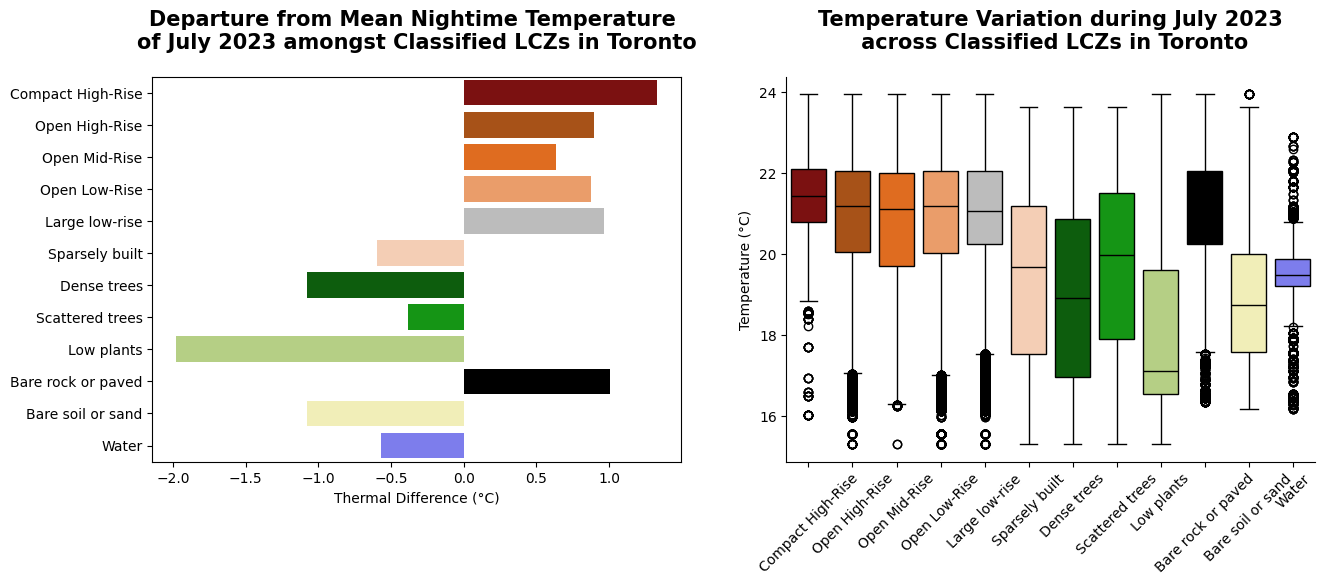

In [3]:


fig, ax = plt.subplots(1,2, figsize=(15,5))


# ## Thermal Departure from Mean Nightime Temperature
plt.sca(ax[0])
lcz_means=stats_df['mean']
mean_temp=np.nanmean(temp_n)

mean_d=lcz_means - mean_temp

sns.barplot(x=mean_d, y= labels, palette=palette, legend=False)
plt.xlabel('Thermal Difference (°C)')
ax[1].set_xlim([-2.0,2.0])
plt.title('Departure from Mean Nightime Temperature \nof July 2023 amongst Classified LCZs in Toronto', fontdict=dict(size= 15, weight='bold'), pad=20)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

## LCZ Class Box Plots
plt.sca(ax[1])
sns.boxplot(data=stats_vals, palette = palette,)
plt.xticks(ticks=list(range(0,len(classes))),labels=labels, rotation=45)
plt.ylabel('Temperature (°C)')
plt.title('Temperature Variation during July 2023\n across Classified LCZs in Toronto', fontdict=dict(size= 15, weight='bold'), pad=20)


plt.savefig('../reports/figures/temp_barplots.png', dpi=300, bbox_inches='tight', )


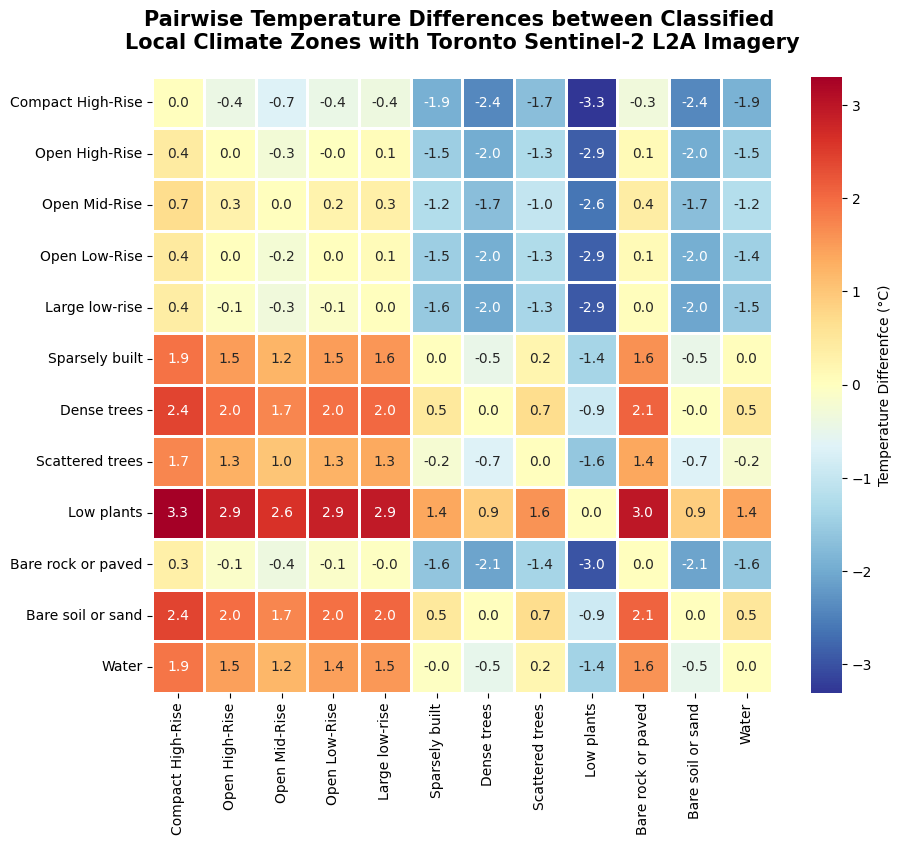

In [4]:
## Pairwise Temperature Differences from LCZ Classes
plt.figure(figsize=(10,8))
mean_vals=stats_df['mean']
mx,my=np.meshgrid(mean_vals,mean_vals)

pairwise_difference = (mx-my)

sns.heatmap(pairwise_difference, 
        annot=True, 
        fmt="0.1f", 
        cmap='RdYlBu_r',
        cbar=True,
        xticklabels=labels, 
        yticklabels=labels, 
        # mask=mask,
        linewidths=1,
        linecolor='white',
        cbar_kws=dict(label='Temperature Differenfce (°C)')
        )

plt.title('Pairwise Temperature Differences between Classified \nLocal Climate Zones with Toronto Sentinel-2 L2A Imagery',fontdict=dict(size= 15, weight='bold'), pad=20)

plt.savefig('../reports/figures/temp_pairwise.png', dpi=300, bbox_inches='tight' )

In [97]:
mean_diff = jul_n - jul_n.mean()

In [75]:
class_mask= (lcz == 6).ravel()

x=lcz_30m.x.values
y=lcz_30m.y.values

xx,yy=np.meshgrid(x,y)

xx,yy=xx.ravel(), yy.ravel()

coords=np.array(list((zip(xx,yy))))

coords_f=coords[class_mask]


clusters=dbscan.fit_predict(coords_f)

In [ ]:

import rasterio
from rasterio.features import shapes
import numpy as np
import geopandas as gpd
from shapely.geometry import shape

# Open raster
with rasterio.open(r'D:\GeoAI\projects\lcz_classification\data\toronto\processed\classification\classified_30m.tif') as src:
    image = src.read(1)  # first band
    transform = src.transform

# Extract shapes from raster
results = (
    {'geometry': shape(geom), 'value': value}
    for geom, value in shapes(image, transform=transform)
    if value != src.nodata
)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame.from_records(results)
gdf = gdf.set_geometry('geometry').set_crs(src.crs)
# Now gdf.geometry contains properly sequenced Polygons or MultiPolygons
gdf['class_name'] = [lcz_legend.set_index('class').loc[int(cl)]['name'] for cl in gdf['value']]


In [ ]:
geom_means=list()


for geom in gdf.geometry:
    x1,y1,x2,y2 = geom.bounds
    temp_clip=mean_diff.sel(x= slice(x1,x2), y=(slice(y2,y1))).values
    temp_mean=np.nanmean(temp_clip)
    geom_means.append(temp_mean)

gdf['mean_temp_diff'] =geom_means

C:\Users\medo_\AppData\Local\Temp\ipykernel_40444\3025281686.py:7: RuntimeWarning: Mean of empty slice
  temp_mean=np.nanmean(temp_clip)


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


KeyboardInterrupt: 

In [116]:
gdf.mean_temp_diff.isna().value_counts()

mean_temp_diff
False    55398
True      1313
Name: count, dtype: int64

In [112]:
gdf.to_parquet('../data/toronto/processed/classification/lcz_temp_diff.parquet')